# How to get and plot the absorption imaging

This is an example to calculate OD from absorption imaging from the loaded data.

Let us start with importing the supporting packages and loading the data. In order to keep things ealier, here we will import all the packages, but not all of them will be used.

## Load some example data

### Import supporting packages

In [1]:
# Set the system path for importing packages
# This is just because I put all example scripts in another folder
# You DO NOT need to do this 
# -------------- You do NOT need following part --------------
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
# -------------- You do NOT need above part --------------

import copy
import glob
from datetime import datetime

# The package for data structure
import xarray as xr
import pandas as pd
import numpy as np

# The packages for working with uncertainties
from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

# The package for plotting
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18 # Set the global font size

# -------------- The modules written by us --------------

# The packages for read data
from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time, read_csv_file

# The packages for data analysis
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

# Add errorbar plot to xarray package
from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

### Start a client for parallel computing

In [2]:
from dask.distributed import Client
client = Client(n_workers=6, threads_per_worker=10, processes=True, memory_limit='10GB')
client

<Client: 'tcp://127.0.0.1:62024' processes=6 threads=60, memory=55.88 GiB>

### Set the path for different cameras

In [3]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    "images/ODT_1_Axis_Camera/in_situ_absorption",
    "images/ODT_2_Axis_Camera/in_situ_absorption",
]

# give a short name to each path (or let's say each camera)
dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_0",
    "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_1",
    "images/ODT_2_Axis_Camera/in_situ_absorption": "camera_2",
}

### Set global path for experiment

In [4]:
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + '2023/04/17'# get_date()

### Load shot 0058

In [5]:
shotNum = "0058"
filePath = folderPath + "/" + shotNum + "/*.h5"

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
    for i in [0] # range(len(groupList)) # uncommont to load data for all three cameras
}
dataSet = dataSetDict["camera_0"]

dataSet = swap_xy(dataSet)

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)

dataSet

<xarray.Dataset>
Dimensions:           (runs: 5, truncation_value: 11, y: 1200, x: 1920)
Coordinates:
  * runs              (runs) float64 0.0 1.0 2.0 3.0 4.0
  * truncation_value  (truncation_value) float64 0.8 0.83 0.85 ... 0.97 0.99 1.0
Dimensions without coordinates: y, x
Data variables:
    atoms             (runs, truncation_value, y, x) uint16 dask.array<chunksize=(5, 11, 1200, 1920), meta=np.ndarray>
    background        (runs, truncation_value, y, x) uint16 dask.array<chunksize=(5, 11, 1200, 1920), meta=np.ndarray>
    dark              (runs, truncation_value, y, x) uint16 dask.array<chunksize=(5, 11, 1200, 1920), meta=np.ndarray>
    shotNum           (runs, truncation_value) <U2 dask.array<chunksize=(5, 11), meta=np.ndarray>
Attributes: (12/100)
    TOF_free:                          0.02
    abs_img_freq:                      110.866
    absorption_imaging_flag:           True
    backup_data:                       True
    blink_off_time:                    nan
    blink_on_time:                     nan
    ...                                ...
    z_offset:                          0.195
    z_offset_img:                      0.195
    truncation_value:                  [0.8  0.83 0.85 0.87 0.89 0.91 0.93 0....
    runs:                              [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1...
    scanAxis:                          ['runs' 'truncation_value']
    scanAxisLength:                    [55. 55.]

## Creat an object of imaging analyser 

The idea is to package all imaging related analysis funciton into a clasee, the 'ImageAnalyser'. The advantage is that it record our last settings, i.e. the region of interest, and thus we don't need to set it again.

Therefore, first we need to create an object of the 'ImageAnalyser' class.

In [6]:
imageAnalyser = ImageAnalyser()

## Calculate OD of absorption imaging

A brief introduction to the absorption iamging can be found in following link

https://arxiv.org/pdf/1209.3408.pdf

You now can directly call the function ImageAnalyser.get_absorption_images() to get the OD of aborption imging from the loaded data. It will return a copy of the data and add the calculation result with a name 'OD'.

In [7]:
dataSet = imageAnalyser.get_absorption_images(dataSet)
dataSet

<xarray.Dataset>
Dimensions:           (runs: 5, truncation_value: 11, y: 1200, x: 1920)
Coordinates:
  * runs              (runs) float64 0.0 1.0 2.0 3.0 4.0
  * truncation_value  (truncation_value) float64 0.8 0.83 0.85 ... 0.97 0.99 1.0
Dimensions without coordinates: y, x
Data variables:
    atoms             (runs, truncation_value, y, x) uint16 dask.array<chunksize=(5, 11, 1200, 1920), meta=np.ndarray>
    background        (runs, truncation_value, y, x) uint16 dask.array<chunksize=(5, 11, 1200, 1920), meta=np.ndarray>
    dark              (runs, truncation_value, y, x) uint16 dask.array<chunksize=(5, 11, 1200, 1920), meta=np.ndarray>
    shotNum           (runs, truncation_value) <U2 dask.array<chunksize=(5, 11), meta=np.ndarray>
    OD                (runs, truncation_value, y, x) float64 dask.array<chunksize=(5, 11, 1200, 1920), meta=np.ndarray>
Attributes: (12/100)
    TOF_free:                          0.02
    abs_img_freq:                      110.866
    absorption_imaging_flag:           True
    backup_data:                       True
    blink_off_time:                    nan
    blink_on_time:                     nan
    ...                                ...
    z_offset:                          0.195
    z_offset_img:                      0.195
    truncation_value:                  [0.8  0.83 0.85 0.87 0.89 0.91 0.93 0....
    runs:                              [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1...
    scanAxis:                          ['runs' 'truncation_value']
    scanAxisLength:                    [55. 55.]

## Crop the region of interest

The next thing we usually need to do is to select the region of interest (ROI).

In [8]:
imageAnalyser.center = (960, 875)
imageAnalyser.span = (300, 300)
imageAnalyser.fraction = (0.1, 0.1)

The object of the ImageAnalyser will save the information until we change it, so we don't need to tell it again and again.

Here the 
- center: the center of the ROI as a tuple (center of x, center of y)
- span: the span of the ROI as a tuple (span of x, span of y)
- fraction: the fraction of the region at the conner of ROI to calculate the background. It is in a format of a tuple (fraction of x, fraction of y)

Then we can crop the images and remove the background.

In [9]:
dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()
dataSet_cropOD

<xarray.DataArray 'OD' (runs: 5, truncation_value: 11, y: 300, x: 300)>
array([[[[ 0.10089884,  0.0696463 ,  0.05767011, ...,  0.01963588,
          -0.0650863 , -0.00446167],
         [ 0.10342729,  0.04260584,  0.02118076, ...,  0.11194868,
           0.00723437, -0.0801735 ],
         [ 0.00780842,  0.00827735, -0.02827232, ..., -0.02693453,
          -0.00446167,  0.0622297 ],
         ...,
         [-0.1117072 , -0.0575715 , -0.03836323, ..., -0.05152918,
          -0.02529576,  0.00751452],
         [ 0.12183205,  0.03190597,  0.01355683, ..., -0.02573907,
          -0.05682966, -0.00446167],
         [ 0.03475904,  0.0325796 ,  0.07721636, ...,  0.02662891,
          -0.05738408,  0.00751452]],

        [[ 0.05613155, -0.10849043,  0.05082337, ...,  0.09902547,
           0.01710835,  0.03692657],
         [-0.08110418, -0.09280022,  0.01710835, ..., -0.04168176,
          -0.15458948,  0.00483825],
         [-0.07212279, -0.00743184, -0.05653069, ..., -0.18356235,
          -0.01621516, -0.07006305],
...
         [ 0.15678264,  0.09630046,  0.1255301 , ..., -0.00355249,
           0.01855798, -0.00499196],
         [ 0.00774706, -0.07926432,  0.0260962 , ..., -0.01447608,
          -0.03527032,  0.04126975],
         [-0.01094507, -0.16745703, -0.0624572 , ...,  0.07159853,
           0.01769739, -0.06124581]],

        [[ 0.05950001,  0.0086876 , -0.02921711, ...,  0.04073558,
          -0.00421581, -0.04723319],
         [-0.0555091 , -0.11475768, -0.05360856, ..., -0.01551536,
           0.03087551, -0.00421581],
         [ 0.03352452, -0.01663833,  0.01931469, ...,  0.01752418,
          -0.02504989,  0.04815218],
         ...,
         [ 0.03087551,  0.05294261, -0.13050953, ..., -0.0277463 ,
          -0.05020092, -0.04014782],
         [ 0.03352452, -0.04422114, -0.06030527, ..., -0.06009626,
          -0.03467501,  0.09642772],
         [-0.04125708,  0.01447633,  0.07129175, ...,  0.06247557,
          -0.05947848, -0.01538911]]]])
Coordinates:
  * runs              (runs) float64 0.0 1.0 2.0 3.0 4.0
  * truncation_value  (truncation_value) float64 0.8 0.83 0.85 ... 0.97 0.99 1.0
Dimensions without coordinates: y, x
Attributes:
    IMAGE_SUBCLASS:       IMAGE_GRAYSCALE
    IMAGE_VERSION:        1.2
    IMAGE_WHITE_IS_ZERO:  0
    x_start:              810
    x_end:                1110
    y_end:                1025
    y_start:              725
    x_center:             960
    y_center:             875
    x_span:               300
    y_span:               300

The information of ROI will be written to the attributes of the images.

## Plot the OD images

Like panadas package, xarray also provide a easy function to plot the results. Here is an link ot the introduction

https://docs.xarray.dev/en/stable/user-guide/plotting.html

`The original xarray plotting function doesn't support to do an errorbar plot, but we implement it by ourselves.`

If you do not have any patient to read it, you can always copy and paste the following sentance, but with some different settings.

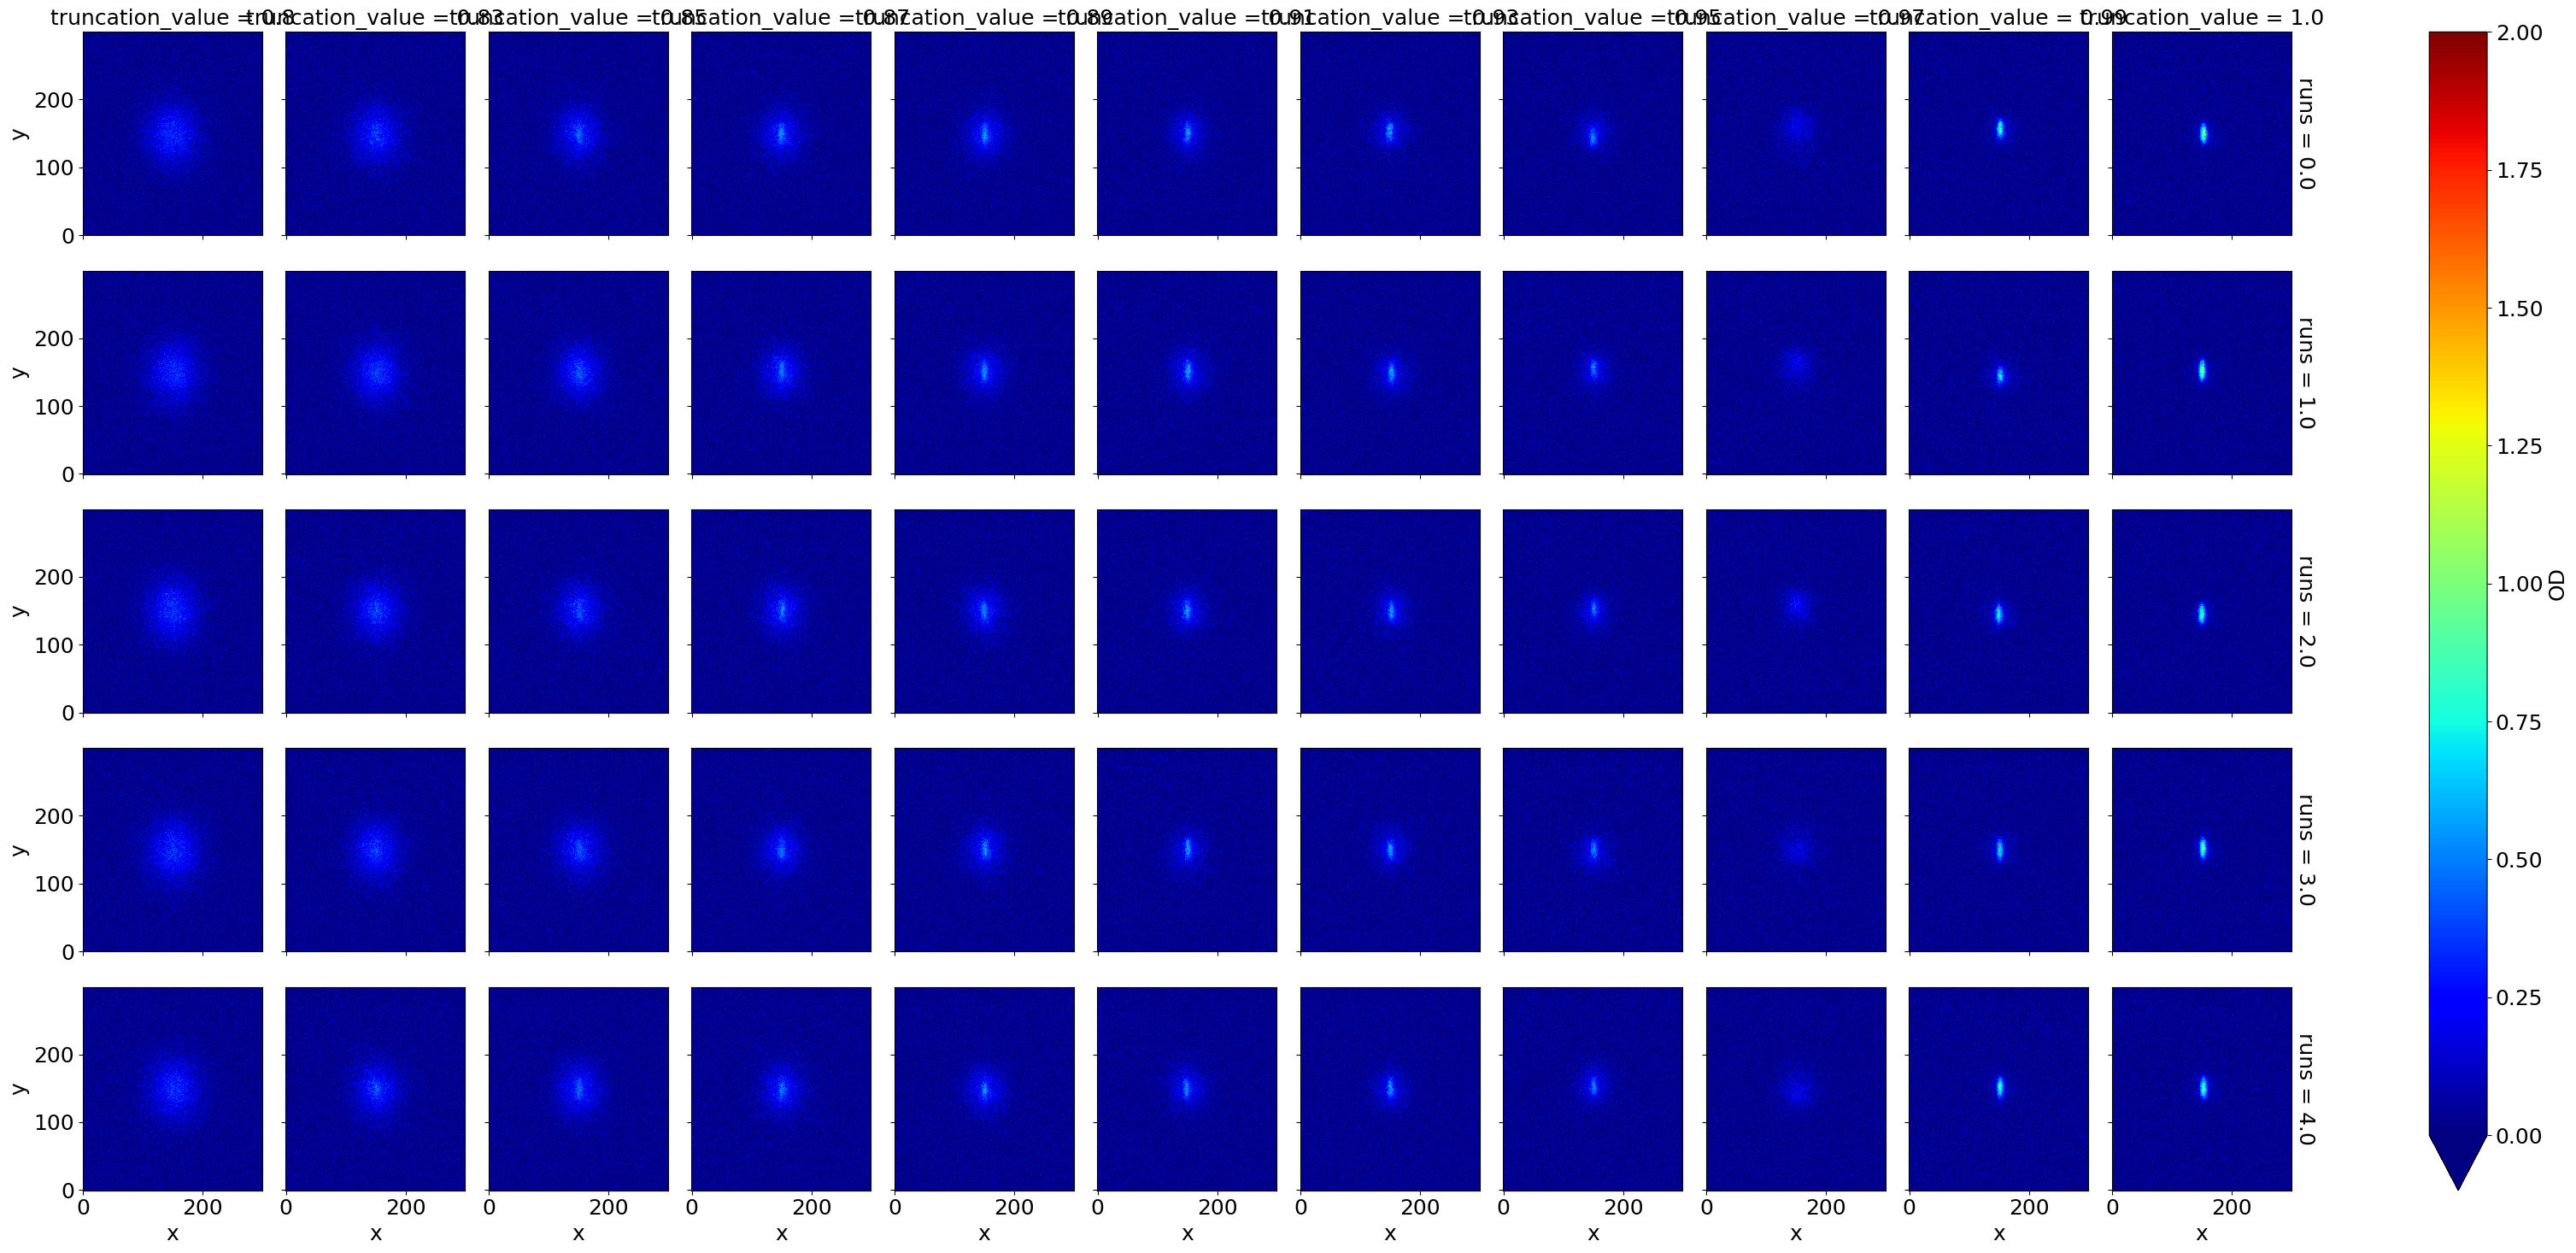

In [10]:
# first get the scan axes
scanAxis = get_scanAxis(dataSet)

# Name_of_varibale.plot.name_of_plot_type(col=scanAxis[0], row=scanAxis[1], **kwargs)
# The name of the plot type has the same name as it in the matplotlib package
# The **kwargs to adjust the plot also as same as the matplotlib package
dataSet_cropOD.plot.pcolormesh(col=scanAxis[0], row=scanAxis[1], cmap='jet', vmin=0, vmax=2)

plt.show()